# Grid Trials

In order to investigate the effect that the grid has on the mass accumulation, four grids have been generated, and the data used. 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import re
from shapely.geometry import Point
from geopandas import GeoDataFrame

## Input Parameters

For this investigation, the same input variables are used as in previous reports.

The most contentious variables, DIFFUSION_KOEFFICIENT ($K$) and FALL_TIME_THRESHOLD (FTT), are set to 1000 and 3600 s respectively. These are currently thought to be the most realistic settings, but will be confirmed once the effect of the grid has been established. 

In [3]:
VENT_EASTING = 0
VENT_NORTHING = 0
VENT_ELEVATION = 1
PLUME_HEIGHT = 25000
ALPHA = 1.04487
BETA = 1.46425
ERUPTION_MASS = 1882315000000.0
MAX_GRAINSIZE = -4.5
MIN_GRAINSIZE = 4.5
MEDIAN_GRAINSIZE = 0
STD_GRAINSIZE = 1.8
EDDY_CONST = 0.04
DIFFUSION_COEFFICIENT = 1000
FALL_TIME_THRESHOLD = 3600
LITHIC_DENSITY = 2700.0
PUMICE_DENSITY = 1000.0
COL_STEPS = 75
PART_STEPS = 8
PLUME_MODEL = 2

## Grid Generation

In previous reports the grid generation algorithm has come into question. The code below shows the rewritten grid generation algorithm. This one does not cause massive over accumulation like the previous version. 

Also included is a script to write a grid file, and a script to read in TEPHRA2 output data. 

In [4]:
def construct_grid(vent, points_north, points_east, points_south, \
                   points_west, elevation, spacing):
    width = points_west + points_east + 1
    length = points_south + points_north + 1
    
    xx, yy = np.meshgrid(np.linspace(-points_west, points_east, width),\
                         np.linspace(-points_south, points_north, length))
    xx = xx*spacing + vent[0]
    yy = yy*spacing + vent[1]

    xx = xx.ravel()
    yy = yy.ravel()
    zz = [elevation]*len(xx)
    
    d = {'Easting': xx, 'Northing': yy, 'Elev.': zz}
    df = pd.DataFrame(data=d)
    return df

def write_grid_file(df, filename):
    df.to_csv(filename, sep=' ', columns=['Easting', 'Northing', 'Elev.'],
              index=False, header=False)

    
def tephra2_to_df(filename):
    # Reads input from Tephra2 into a GeoPandas GeoDataFrame
    # Geopandas is used to enable easy spatial calculations
    # (area, distance, etc.)

    # Extract phi-classes from header and construct col names
    headers = pd.read_csv(filename, sep=" ", header=None, nrows=1)
    phi_labels = []
    phi_limits = []
    phi_centroids = []
    for name in headers[headers.columns[4:-1]].values[0]:
        m1 = re.search(r'[-+]?[0-9]*\.?[0-9]+(?=->)', name)
        m2 = re.search(r'[-+]?[0-9]*\.?[0-9]+(?=\))', name)
        phi_labels.append("[" + m1.group(0) + "," + m2.group(0) + ")")
        phi_limits.append((m1.group(0), m2.group(0)))
        phi_centroids.append((float(m1.group(0)) + float(m2.group(0))) / 2)
    col_names = ["Easting", "Northing", "Elevation",
                 "MassArea"] + phi_labels + ["Percent"]

    df = pd.read_csv(filename, sep=" ", header=None,
                     names=col_names, skiprows=1)
    df = df.dropna(axis=1, how='all')
    df = df.fillna(0)

    geometry = [Point(xy) for xy in zip(df.Easting, df.Northing)]
    crs = {'init': 'epsg:4326'}
    df = GeoDataFrame(df.copy(), crs=crs, geometry=geometry)
    return df, phi_labels, phi_limits, phi_centroids

## Internal TEPHRA2 Data

During the excecution TEPHRA2, the input data is used to initialise a data set upon which the accumulation algorithm is performed. 

We were able to write some of this data to a file to see what is being used internally by TEPHRA2. 

#### Grain-size distribution

Within TEPHRA2, the grain size distribution is calculated as a unimodal normal distribution, based on the input parameters:
 - MAX_GRAINSIZE = -4.5
 - MIN_GRAINSIZE = 4.5
 - MEDIAN_GRAINSIZE = 0
 - STD_GRAINSIZE = 1.8

Internally, this normal distribution represented as a discritized pdf with a number of bins specified by the parameter PART_STEPS, which is set to 8 in our simulations.

We were able to write the contents of this discritized pdf directly to a file, and compare it with:
 - The theoretical density function based on the input parameters, and 
 - The grain size distribution reconstructed from simulated data. 
 
 In this way, we aim to draw conclusions about the nature of the apparent mass loss that was observed before. 
 





## Grid Creation

Four grids were used in this investigation. 

#### Grid 1: Control

The first grid is similar to grids used in previous reports. On each side of the vent there are 100 (N) points in each wind direction. Points are spaced 1000 m apart in all directions. Therefore, Grid 1 has a total of 201$\times$201 = 40401 points. The square area is 201 km on each side, and covers a total area of (201 km)$^2$, or 40401 km$^2$. Each point is in the middle of a 1000 m by 1000 m square Voronoi cell, which is used to calculate the total mass. 

#### Grid 2: Extended

The second grid is the same as the first, except that it has *more points* added to the grid in each direction. 
Grid 1 has a total of 401$\times$401 = 160801 points. The square area is 401 km on each side, and covers a total area of (401 km)$^2$, or 160801 km$^2$. 

#### Grid 3: Finer

The third grid covers the same area as the control grid (40401 km$^2$), but has less spacing between points (500 m in each direction), and therefore has more points (160801 points). Each point is in the middle of a 500$\times$500 m$^2$ square Voronoi cell. 

#### Grid 4: Expanded

The fourth grid has the same number of points as the first (40401 points), but they are spread further apart, with 2000 m between points. This grid therefore covers a total area of 160801 km$^2$, and each grid falls in the center of a square voronoi cell with an area of 2000$\times$2000 m$^2$. 


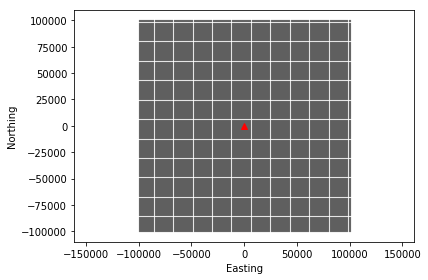

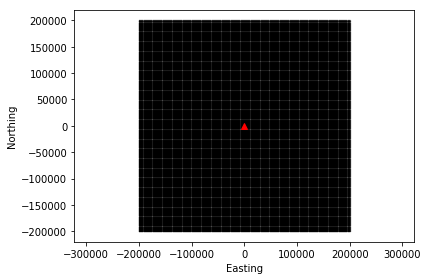

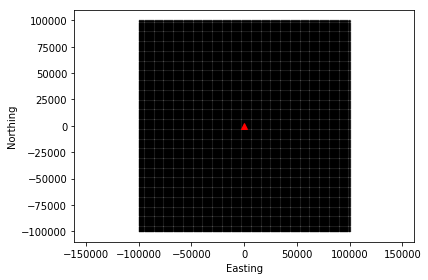

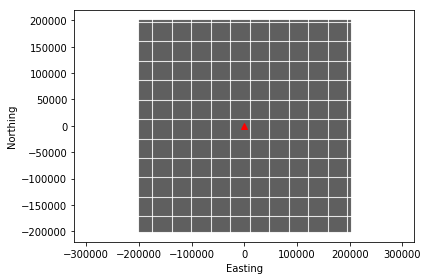

In [18]:
vent = (0, 0)

N = 100
D = 1000

# Case 1: Control
df_c1 = construct_grid(vent, 
                         points_east =N, 
                         points_west =N, 
                         points_north=N, 
                         points_south=N, 
                         elevation=1, spacing=D)

# Case 2: Extended
df_c2 = construct_grid(vent, 
                         points_east =2*N, 
                         points_west =2*N, 
                         points_north=2*N, 
                         points_south=2*N, 
                         elevation=1, spacing=D)

# Case 3: Finer
df_c3 = construct_grid(vent, 
                         points_east =2*N, 
                         points_west =2*N, 
                         points_north=2*N, 
                         points_south=2*N, 
                         elevation=1, spacing=D/2)

# Case 4: Expanded
df_c4 = construct_grid(vent, 
                         points_east =N, 
                         points_west =N, 
                         points_north=N, 
                         points_south=N, 
                         elevation=1, spacing=2*D)

df_c1.plot.scatter("Easting", "Northing", color='k', marker='.', s=0.2)
plt.plot(vent[0], vent[1], 'r^')
plt.axis('equal')
plt.tight_layout()
plt.show()
write_grid_file(df_c1, "c1.txt")

df_c2.plot.scatter("Easting", "Northing", color='k', marker='.', s=0.2)
plt.plot(vent[0], vent[1], 'r^')
plt.axis('equal')
plt.tight_layout()
plt.show()
write_grid_file(df_c2, "c2.txt")

df_c3.plot.scatter("Easting", "Northing", color='k', marker='.', s=0.2)
plt.plot(vent[0], vent[1], 'r^')
plt.axis('equal')
plt.tight_layout()
plt.show()
write_grid_file(df_c3, "c3.txt")

df_c4.plot.scatter("Easting", "Northing", color='k', marker='.', s=0.2)
plt.plot(vent[0], vent[1], 'r^')
plt.axis('equal')
plt.tight_layout()
plt.show()
write_grid_file(df_c4, "c4.txt")

## Case 1: Control

In [16]:
mass_data_c1 = pd.read_csv("./grid_trials/c1/mass_initialisation.csv")
out_data_c1, phi_labels_c1, phi_limits_c1, phi_centroids_c1 = \
        tephra2_to_df("./grid_trials/c1/c1_out.txt")
gs_data_c1 = pd.read_csv("./grid_trials/c1/grain_size_dist.out")


print(mass_data_c1.head().to_latex(index=False))
print(gs_data_c1.to_latex(index=False))
print(out_data_c1.head().to_latex(index=False))


\begin{tabular}{rrrrrrrrrrrr}
\toprule
 gs\_step &  col\_step &  particle\_ht &   ashdiam &  part\_density &  fall\_time &  plume\_diffusion\_fine\_particle &  plume\_diffusion\_coarse\_particle &  total\_fall\_time &  wind\_sum\_x &  wind\_sum\_y &   actual\_mass \\
\midrule
       0 &         0 &       334.32 &  0.022627 &        1000.0 &  14.157108 &                      54.789974 &                         0.355527 &        14.157108 &         0.0 &         0.0 &  3.568469e+08 \\
       0 &         1 &       667.64 &  0.000000 &           0.0 &  13.872278 &                      95.394886 &                         1.422108 &        28.029386 &         0.0 &         0.0 &  3.658019e+08 \\
       0 &         2 &      1000.96 &  0.000000 &           0.0 &  13.593178 &                     131.946569 &                         3.199744 &        41.622564 &         0.0 &         0.0 &  3.701401e+08 \\
       0 &         3 &      1334.28 &  0.000000 &           0.0 &  13.319693 &            

In [19]:
out_mass_c1 = (D**2) * out_data_c1["MassArea"]
out_tot_mass = out_mass_c1.sum()
out_mass_prop = (out_tot_mass/ERUPTION_MASS)


table_data = {
    "Input Mass":ERUPTION_MASS,
    "Internal Mass":mass_data_c1.actual_mass.sum(),
    "Internal Mass/Input Mass":mass_data_c1.actual_mass.sum()/ERUPTION_MASS,
    "Output Mass":out_tot_mass,
    "Output Mass/Input Mass":out_mass_prop
}

table = pd.DataFrame(data=table_data, index=[""])
table.T
print(table.T.to_latex())


\begin{tabular}{lr}
\toprule
{} \\
\midrule
Input Mass               &  1.882315e+12 \\
Internal Mass            &  1.882315e+12 \\
Internal Mass/Input Mass &  1.000000e+00 \\
Output Mass              &  1.894306e+12 \\
Output Mass/Input Mass   &  1.006370e+00 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  col\_step &  particle\_ht &   ashdiam &  part\_density &     fall\_time &  plume\_diffusion\_fine\_particle &  plume\_diffusion\_coarse\_particle &  total\_fall\_time &  wind\_sum\_x &  wind\_sum\_y &   actual\_mass \\
gs\_step &           &              &           &               &               &                                &                                  &                  &             &             &               \\
\midrule
0       &      2775 &     950037.0 &  0.022627 &     1000.0000 &    550.426104 &                   73061.537267 &                      51000.36417 &     2.596674e+04 &         0.0 &         0.0 &  2.093962e+10 \\
1       &      2775 &     950037.0 &  0.010375 &     1000.0000 &    812.883662 &                   73061.537267 &                      51000.36417 &     3.834836e+04 &         0.0 &         0.0 &  8.217329e+10 \\
2       &      2775 &     950037.0 &  0.004757 &     1000.0000 &   1200.487845 &       

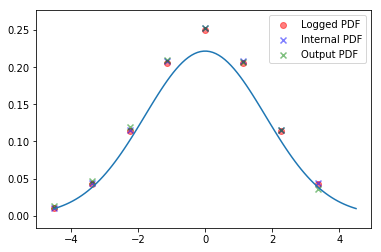

In [22]:
agg_per_gs_c1 = mass_data_c1.groupby("gs_step").sum()
# display(agg_per_gs_c1)

print(agg_per_gs_c1.to_latex())

mass_per_gs_c1 = agg_per_gs_c1.actual_mass
phi_left_c1 = -np.log2(agg_per_gs_c1.ashdiam/.001)


norm_mass_per_gs_c1 = mass_per_gs_c1.values/mass_per_gs_c1.values.sum()

out_gs_mass_c1 = pd.DataFrame(columns=phi_labels_c1)

for phi in phi_labels_c1:
    out_gs_mass_c1[phi] = out_data_c1.MassArea * out_data_c1[phi]

tot_out_gs_mass_c1 = out_gs_mass_c1.sum()
norm_out_gs_mass_c1 = tot_out_gs_mass_c1/tot_out_gs_mass_c1.values.sum()


x = np.linspace(-4.5,4.5, 100)
plt.scatter(gs_data_c1.Y, gs_data_c1.Prob, color='r', alpha=0.5, 
            label="Logged PDF")
plt.scatter(phi_left_c1, norm_mass_per_gs_c1, alpha=0.5, color='b', 
            label="Internal PDF", marker='x')
plt.scatter(phi_left_c1, norm_out_gs_mass_c1, alpha=0.5, color='g', 
            label="Output PDF", marker='x')
plt.plot(x, stats.norm.pdf(x, MEDIAN_GRAINSIZE, STD_GRAINSIZE))
plt.legend()
plt.show()

## Case 2: Extended Grid

In [130]:
mass_data_c2 = pd.read_csv("./grid_trials/c2/mass_initialisation.csv")
out_data_c2, phi_labels_c2, phi_limits_c2, phi_centroids_c2 = \
            tephra2_to_df("./grid_trials/c2/c2_out.txt")
gs_data_c2 = pd.read_csv("./grid_trials/c2/grain_size_dist.out")
display(mass_data_c2.head())
display(out_data_c2.head())
display(gs_data_c2)

,gs_step,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
0,0,0,334.32,0.022627,1000.0,14.157108,54.789974,0.355527,14.157108,0.0,0.0,3.568469e+08
1,0,1,667.64,0.000000,0.0,13.872278,95.394886,1.422108,28.029386,0.0,0.0,3.658019e+08
2,0,2,1000.96,0.000000,0.0,13.593178,131.946569,3.199744,41.622564,0.0,0.0,3.701401e+08
3,0,3,1334.28,0.000000,0.0,13.319693,166.092143,5.688434,54.942257,0.0,0.0,3.725223e+08
4,0,4,1667.60,0.000000,0.0,13.051711,198.553296,8.888178,67.993968,0.0,0.0,3.738012e+08


,Easting,Northing,Elevation,MassArea,"[-4.5,-3.375)","[-3.375,-2.25)","[-2.25,-1.125)","[-1.125,0)","[0,1.125)","[1.125,2.25)","[2.25,3.375)","[3.375,4.5)",geometry
0,-200000,-200000,1,0.005262,0.0,0.0,0.0,0.0,0.0,2.605090e-90,9.230070e-17,100.0,POINT (-200000 -200000)
1,-199000,-200000,1,0.005358,0.0,0.0,0.0,0.0,0.0,7.517680e-90,1.138340e-16,100.0,POINT (-199000 -200000)
2,-198000,-200000,1,0.005456,0.0,0.0,0.0,0.0,0.0,2.157880e-89,1.402430e-16,100.0,POINT (-198000 -200000)
3,-197000,-200000,1,0.005556,0.0,0.0,0.0,0.0,0.0,6.161080e-89,1.725980e-16,100.0,POINT (-197000 -200000)
4,-196000,-200000,1,0.005657,0.0,0.0,0.0,0.0,0.0,1.749730e-88,2.121950e-16,100.0,POINT (-196000 -200000)


,Index,Y,Prob,Cumulative
0,0,-4.500,0.010955,0.010955
1,1,-3.375,0.042991,0.053947
2,2,-2.250,0.114156,0.168102
3,3,-1.125,0.205101,0.373203
4,4,0.000,0.249339,0.622542
5,5,1.125,0.205101,0.827643
6,6,2.250,0.114156,0.941798
7,7,3.375,0.042991,0.984790


In [131]:
out_mass_c2 = (D**2) * out_data_c2["MassArea"]
out_tot_mass = out_mass_c2.sum()
out_mass_prop = (out_tot_mass/ERUPTION_MASS)


table_data = {
    "Input Mass":ERUPTION_MASS,
    "Internal Mass":mass_data_c2.actual_mass.sum(),
    "Internal Mass/Input Mass":mass_data_c2.actual_mass.sum()/ERUPTION_MASS,
    "Output Mass":out_tot_mass,
    "Output Mass/Input Mass":out_mass_prop
}

table = pd.DataFrame(data=table_data, index=[""])
table.T
display(table.T)


,
Input Mass,1.882315e+12
Internal Mass,1.882315e+12
Internal Mass/Input Mass,1.000000e+00
Output Mass,1.905622e+12
Output Mass/Input Mass,1.012382e+00


,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
gs_step,,,,,,,,,,,
0,2775,950037.0,0.022627,1000.0000,550.426104,73061.537267,51000.36417,2.596674e+04,0.0,0.0,2.093962e+10
1,2775,950037.0,0.010375,1000.0000,812.883662,73061.537267,51000.36417,3.834836e+04,0.0,0.0,8.217329e+10
2,2775,950037.0,0.004757,1000.0000,1200.487845,73061.537267,51000.36417,5.663386e+04,0.0,0.0,2.181958e+11
3,2775,950037.0,0.002181,1000.0000,1853.781601,73061.537267,51000.36417,8.488783e+04,0.0,0.0,3.920269e+11
4,2775,950037.0,0.001000,1212.5000,3292.358471,73061.537267,51000.36417,1.456656e+05,0.0,0.0,4.765835e+11
5,2775,950037.0,0.000459,1451.5625,6368.881937,73061.537267,51000.36417,2.817819e+05,0.0,0.0,3.920269e+11
6,2775,950037.0,0.000210,1690.6250,13482.713942,73061.537267,51000.36417,5.661171e+05,0.0,0.0,2.181958e+11
7,2775,950037.0,0.000096,1929.6875,46885.181838,73061.537267,51000.36417,1.781637e+06,0.0,0.0,8.217329e+10


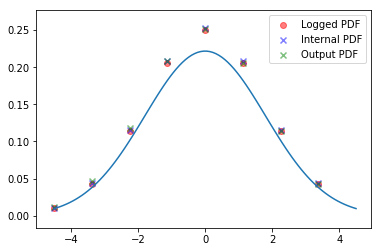

In [132]:
agg_per_gs_c2 = mass_data_c2.groupby("gs_step").sum()
display(agg_per_gs_c2)
mass_per_gs_c2 = agg_per_gs_c2.actual_mass
phi_left_c2 = -np.log2(agg_per_gs_c2.ashdiam/.001)


norm_mass_per_gs_c2 = mass_per_gs_c2.values/mass_per_gs_c2.values.sum()

out_gs_mass_c2 = pd.DataFrame(columns=phi_labels_c2)

for phi in phi_labels_c2:
    out_gs_mass_c2[phi] = out_data_c2.MassArea * out_data_c2[phi]

tot_out_gs_mass_c2 = out_gs_mass_c2.sum()
norm_out_gs_mass_c2 = tot_out_gs_mass_c2/tot_out_gs_mass_c2.values.sum()


x = np.linspace(-4.5,4.5, 100)
plt.scatter(gs_data_c2.Y, gs_data_c2.Prob, color='r', alpha=0.5, 
            label="Logged PDF")
plt.scatter(phi_left_c2, norm_mass_per_gs_c2, alpha=0.5, color='b', 
            label="Internal PDF", marker='x')
plt.scatter(phi_left_c2, norm_out_gs_mass_c2, alpha=0.5, color='g', 
            label="Output PDF", marker='x')
plt.plot(x, stats.norm.pdf(x, MEDIAN_GRAINSIZE, STD_GRAINSIZE))
plt.legend()
plt.show()

## Case 3: Finer Grid

In [133]:
mass_data_c3 = pd.read_csv("./grid_trials/c3/mass_initialisation.csv")
out_data_c3, phi_labels_c3, phi_limits_c3, phi_centroids_c3 = \
        tephra2_to_df("./grid_trials/c3/c3_out.txt")
gs_data_c3 = pd.read_csv("./grid_trials/c3/grain_size_dist.out")
display(mass_data_c3.head())
display(out_data_c3.head())
display(gs_data_c3)


,gs_step,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
0,0,0,334.32,0.022627,1000.0,14.157108,54.789974,0.355527,14.157108,0.0,0.0,3.568469e+08
1,0,1,667.64,0.000000,0.0,13.872278,95.394886,1.422108,28.029386,0.0,0.0,3.658019e+08
2,0,2,1000.96,0.000000,0.0,13.593178,131.946569,3.199744,41.622564,0.0,0.0,3.701401e+08
3,0,3,1334.28,0.000000,0.0,13.319693,166.092143,5.688434,54.942257,0.0,0.0,3.725223e+08
4,0,4,1667.60,0.000000,0.0,13.051711,198.553296,8.888178,67.993968,0.0,0.0,3.738012e+08


,Easting,Northing,Elevation,MassArea,"[-4.5,-3.375)","[-3.375,-2.25)","[-2.25,-1.125)","[-1.125,0)","[0,1.125)","[1.125,2.25)","[2.25,3.375)","[3.375,4.5)",geometry
0,-100000,-100000,1,0.156509,0.0,0.0,0.0,0.0,0.0,3.477210e-21,0.005327,99.9947,POINT (-100000 -100000)
1,-99500,-100000,1,0.157804,0.0,0.0,0.0,0.0,0.0,4.531370e-21,0.005620,99.9944,POINT (-99500 -100000)
2,-99000,-100000,1,0.159107,0.0,0.0,0.0,0.0,0.0,5.897320e-21,0.005928,99.9941,POINT (-99000 -100000)
3,-98500,-100000,1,0.160418,0.0,0.0,0.0,0.0,0.0,7.664900e-21,0.006251,99.9937,POINT (-98500 -100000)
4,-98000,-100000,1,0.161736,0.0,0.0,0.0,0.0,0.0,9.949130e-21,0.006590,99.9934,POINT (-98000 -100000)


,Index,Y,Prob,Cumulative
0,0,-4.500,0.010955,0.010955
1,1,-3.375,0.042991,0.053947
2,2,-2.250,0.114156,0.168102
3,3,-1.125,0.205101,0.373203
4,4,0.000,0.249339,0.622542
5,5,1.125,0.205101,0.827643
6,6,2.250,0.114156,0.941798
7,7,3.375,0.042991,0.984790


In [140]:

out_mass_c3 = ((D/2)**2) * out_data_c3["MassArea"]
out_tot_mass = out_mass_c3.sum()
out_mass_prop = (out_tot_mass/ERUPTION_MASS)


table_data = {
    "Input Mass":ERUPTION_MASS,
    "Internal Mass":mass_data_c3.actual_mass.sum(),
    "Internal Mass/Input Mass":mass_data_c3.actual_mass.sum()/ERUPTION_MASS,
    "Output Mass":out_tot_mass,
    "Output Mass/Input Mass":out_mass_prop
}

table = pd.DataFrame(data=table_data, index=[""])
table.T
display(table.T)

,
Input Mass,1.882315e+12
Internal Mass,1.882315e+12
Internal Mass/Input Mass,1.000000e+00
Output Mass,1.869838e+12
Output Mass/Input Mass,9.933716e-01


,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
gs_step,,,,,,,,,,,
0,2775,950037.0,0.022627,1000.0000,550.426104,73061.537267,51000.36417,2.596674e+04,0.0,0.0,2.093962e+10
1,2775,950037.0,0.010375,1000.0000,812.883662,73061.537267,51000.36417,3.834836e+04,0.0,0.0,8.217329e+10
2,2775,950037.0,0.004757,1000.0000,1200.487845,73061.537267,51000.36417,5.663386e+04,0.0,0.0,2.181958e+11
3,2775,950037.0,0.002181,1000.0000,1853.781601,73061.537267,51000.36417,8.488783e+04,0.0,0.0,3.920269e+11
4,2775,950037.0,0.001000,1212.5000,3292.358471,73061.537267,51000.36417,1.456656e+05,0.0,0.0,4.765835e+11
5,2775,950037.0,0.000459,1451.5625,6368.881937,73061.537267,51000.36417,2.817819e+05,0.0,0.0,3.920269e+11
6,2775,950037.0,0.000210,1690.6250,13482.713942,73061.537267,51000.36417,5.661171e+05,0.0,0.0,2.181958e+11
7,2775,950037.0,0.000096,1929.6875,46885.181838,73061.537267,51000.36417,1.781637e+06,0.0,0.0,8.217329e+10


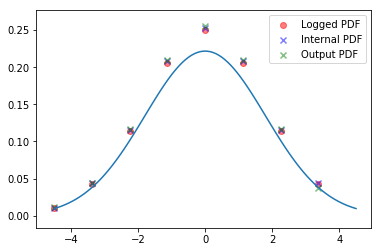

In [141]:
agg_per_gs_c3 = mass_data_c3.groupby("gs_step").sum()
display(agg_per_gs_c3)
mass_per_gs_c3 = agg_per_gs_c3.actual_mass
phi_left_c3 = -np.log2(agg_per_gs_c3.ashdiam/.001)


norm_mass_per_gs_c3 = mass_per_gs_c3.values/mass_per_gs_c3.values.sum()

out_gs_mass_c3 = pd.DataFrame(columns=phi_labels_c3)

for phi in phi_labels_c3:
    out_gs_mass_c3[phi] = out_data_c3.MassArea * out_data_c3[phi]

tot_out_gs_mass_c3 = out_gs_mass_c3.sum()
norm_out_gs_mass_c3 = tot_out_gs_mass_c3/tot_out_gs_mass_c3.values.sum()


x = np.linspace(-4.5,4.5, 100)
plt.scatter(gs_data_c3.Y, gs_data_c3.Prob, color='r', alpha=0.5, 
            label="Logged PDF")
plt.scatter(phi_left_c3, norm_mass_per_gs_c3, alpha=0.5, color='b', 
            label="Internal PDF", marker='x')
plt.scatter(phi_left_c3, norm_out_gs_mass_c3, alpha=0.5, color='g', 
            label="Output PDF", marker='x')
plt.plot(x, stats.norm.pdf(x, MEDIAN_GRAINSIZE, STD_GRAINSIZE))
plt.legend()
plt.show()

## Case 4: Expanded Grid

In [142]:
mass_data_c4 = pd.read_csv("./grid_trials/c4/mass_initialisation.csv")
out_data_c4, phi_labels_c4, phi_limits_c4, phi_centroids_c4 = \
            tephra2_to_df("./grid_trials/c4/c4_out.txt")
gs_data_c4 = pd.read_csv("./grid_trials/c4/grain_size_dist.out")
display(mass_data_c4.head())
display(out_data_c4.head())
display(gs_data_c4)

,gs_step,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
0,0,0,334.32,0.022627,1000.0,14.157108,54.789974,0.355527,14.157108,0.0,0.0,3.568469e+08
1,0,1,667.64,0.000000,0.0,13.872278,95.394886,1.422108,28.029386,0.0,0.0,3.658019e+08
2,0,2,1000.96,0.000000,0.0,13.593178,131.946569,3.199744,41.622564,0.0,0.0,3.701401e+08
3,0,3,1334.28,0.000000,0.0,13.319693,166.092143,5.688434,54.942257,0.0,0.0,3.725223e+08
4,0,4,1667.60,0.000000,0.0,13.051711,198.553296,8.888178,67.993968,0.0,0.0,3.738012e+08


,Easting,Northing,Elevation,MassArea,"[-4.5,-3.375)","[-3.375,-2.25)","[-2.25,-1.125)","[-1.125,0)","[0,1.125)","[1.125,2.25)","[2.25,3.375)","[3.375,4.5)",geometry
0,-200000,-200000,1,0.005262,0.0,0.0,0.0,0.0,0.0,2.605090e-90,9.230070e-17,100.0,POINT (-200000 -200000)
1,-198000,-200000,1,0.005456,0.0,0.0,0.0,0.0,0.0,2.157880e-89,1.402430e-16,100.0,POINT (-198000 -200000)
2,-196000,-200000,1,0.005657,0.0,0.0,0.0,0.0,0.0,1.749730e-88,2.121950e-16,100.0,POINT (-196000 -200000)
3,-194000,-200000,1,0.005863,0.0,0.0,0.0,0.0,0.0,1.388830e-87,3.197190e-16,100.0,POINT (-194000 -200000)
4,-192000,-200000,1,0.006076,0.0,0.0,0.0,0.0,0.0,1.079120e-86,4.797120e-16,100.0,POINT (-192000 -200000)


,Index,Y,Prob,Cumulative
0,0,-4.500,0.010955,0.010955
1,1,-3.375,0.042991,0.053947
2,2,-2.250,0.114156,0.168102
3,3,-1.125,0.205101,0.373203
4,4,0.000,0.249339,0.622542
5,5,1.125,0.205101,0.827643
6,6,2.250,0.114156,0.941798
7,7,3.375,0.042991,0.984790


In [143]:
out_mass_c4 = ((2*D)**2) * out_data_c4["MassArea"]
out_tot_mass = out_mass_c4.sum()
out_mass_prop = (out_tot_mass/ERUPTION_MASS)


table_data = {
    "Input Mass":ERUPTION_MASS,
    "Internal Mass":mass_data_c4.actual_mass.sum(),
    "Internal Mass/Input Mass":mass_data_c4.actual_mass.sum()/ERUPTION_MASS,
    "Output Mass":out_tot_mass,
    "Output Mass/Input Mass":out_mass_prop
}

table = pd.DataFrame(data=table_data, index=[""])
table.T
display(table.T)

,
Input Mass,1.882315e+12
Internal Mass,1.882315e+12
Internal Mass/Input Mass,1.000000e+00
Output Mass,2.171785e+12
Output Mass/Input Mass,1.153784e+00


,col_step,particle_ht,ashdiam,part_density,fall_time,plume_diffusion_fine_particle,plume_diffusion_coarse_particle,total_fall_time,wind_sum_x,wind_sum_y,actual_mass
gs_step,,,,,,,,,,,
0,2775,950037.0,0.022627,1000.0000,550.426104,73061.537267,51000.36417,2.596674e+04,0.0,0.0,2.093962e+10
1,2775,950037.0,0.010375,1000.0000,812.883662,73061.537267,51000.36417,3.834836e+04,0.0,0.0,8.217329e+10
2,2775,950037.0,0.004757,1000.0000,1200.487845,73061.537267,51000.36417,5.663386e+04,0.0,0.0,2.181958e+11
3,2775,950037.0,0.002181,1000.0000,1853.781601,73061.537267,51000.36417,8.488783e+04,0.0,0.0,3.920269e+11
4,2775,950037.0,0.001000,1212.5000,3292.358471,73061.537267,51000.36417,1.456656e+05,0.0,0.0,4.765835e+11
5,2775,950037.0,0.000459,1451.5625,6368.881937,73061.537267,51000.36417,2.817819e+05,0.0,0.0,3.920269e+11
6,2775,950037.0,0.000210,1690.6250,13482.713942,73061.537267,51000.36417,5.661171e+05,0.0,0.0,2.181958e+11
7,2775,950037.0,0.000096,1929.6875,46885.181838,73061.537267,51000.36417,1.781637e+06,0.0,0.0,8.217329e+10


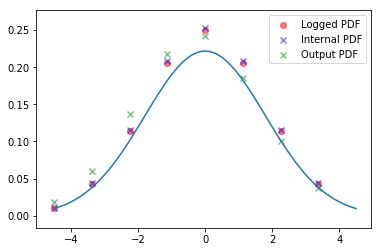

In [138]:
agg_per_gs_c4 = mass_data_c4.groupby("gs_step").sum()
display(agg_per_gs_c4)
mass_per_gs_c4 = agg_per_gs_c4.actual_mass
phi_left_c4 = -np.log2(agg_per_gs_c4.ashdiam/.001)


norm_mass_per_gs_c4 = mass_per_gs_c4.values/mass_per_gs_c4.values.sum()

out_gs_mass_c4 = pd.DataFrame(columns=phi_labels_c4)

for phi in phi_labels_c4:
    out_gs_mass_c4[phi] = out_data_c4.MassArea * out_data_c4[phi]

tot_out_gs_mass_c4 = out_gs_mass_c4.sum()
norm_out_gs_mass_c4 = tot_out_gs_mass_c4/tot_out_gs_mass_c4.values.sum()


x = np.linspace(-4.5,4.5, 100)
plt.scatter(gs_data_c4.Y, gs_data_c4.Prob, color='r', alpha=0.5, 
            label="Logged PDF")
plt.scatter(phi_left_c4, norm_mass_per_gs_c4, alpha=0.5, color='b', 
            label="Internal PDF", marker='x')
plt.scatter(phi_left_c4, norm_out_gs_mass_c4, alpha=0.5, color='g', 
            label="Output PDF", marker='x')
plt.plot(x, stats.norm.pdf(x, MEDIAN_GRAINSIZE, STD_GRAINSIZE))
plt.legend()
plt.show()